# Overview
This is my attempt to solve the first assignment of the Introduction to Machine Learning course, fall 2022.
## Note
Please make sure the dataset is saved in the same working directory as this notebook.

# Preliminary: imports and Loading data

In [37]:
# main imports needed for the rest of the notebook
import os
import math
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
# setting seaborn to darkgrid for a more detailed display of the values
STYLE = 'darkgrid'
sns.set_style(STYLE)

In [38]:
wd = os.getcwd()
dataset_name = "a1_dataset.csv"
file_path = os.path.join(wd, dataset_name) # setting the location of the file 

In [39]:
df_org = pd.read_csv(file_path) # save original datafrae 
df = df_org.copy() # copy to work on

# Exploring the data
It is important to explore the data and better understand to make justified decisions later. My main tools are descriptive statistics, grouping data and aggregating and different types of visulizations.

## general overview: shape, features, types, target distribution

In [40]:
# a general overview of the data
print(df.shape)
print(df.columns)
df.info() # the only column with missing values is 'var4'

(925, 8)
Index(['target', 'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  925 non-null    int64  
 1   var1    925 non-null    float64
 2   var2    925 non-null    float64
 3   var3    925 non-null    object 
 4   var4    325 non-null    float64
 5   var5    925 non-null    float64
 6   var6    925 non-null    object 
 7   var7    925 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 57.9+ KB


In [41]:
# let's rename the columns
new_names = {"target": "y"}
y = df['target']
for i in range(1, len(df.columns) + 1):
    new_names[f'var{str(i)}'] = f"f{str(i)}"
df = df.rename(columns=new_names)
print(df.columns)
# I will drop the target column and add it to the dataframe when needed
df.drop('y', inplace=True, axis=1)

Index(['y', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'], dtype='object')


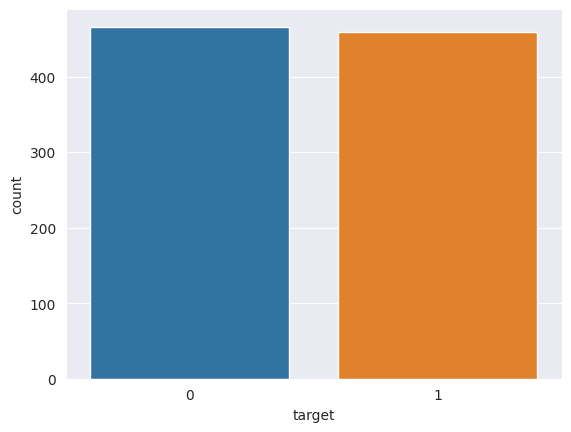

0    466
1    459
Name: target, dtype: int64


In [42]:
sns.countplot(x=y)
plt.show()
print(y.value_counts()) # the dataset is quite balanced: the descriptive statistics back up the visualization

The type of the data determines the set of operations that can be applied on the data. I perform that distinction systematically in the cell below.

In [43]:
# this method returns a tuple of the column names : numerical then categorical
def num_cat(df):
    num = df.select_dtypes(np.number).columns.values
    cat = df.select_dtypes(['object', 'category']).columns.values
    return num, cat


num_cols, cat_cols = num_cat(df)

## Analysing features:
In this subsection, I explore the interaction between the features and the target variable.

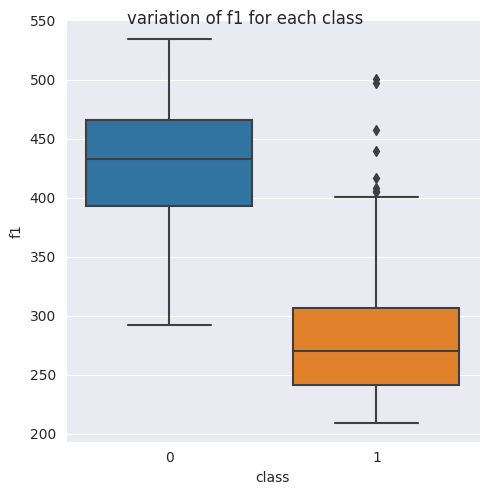

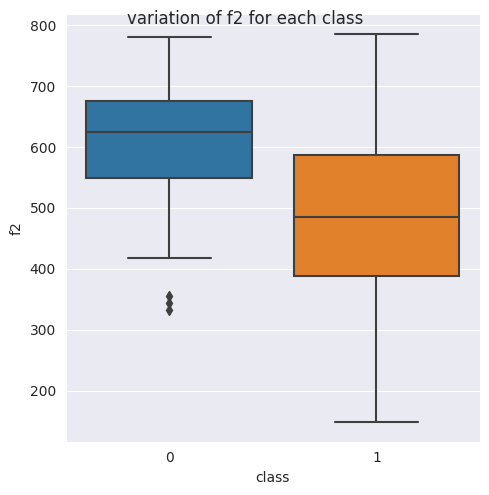

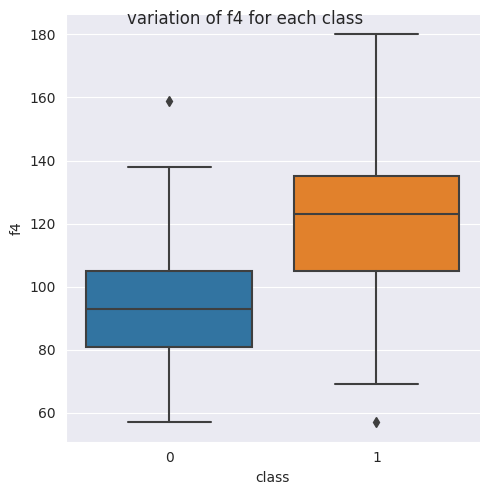

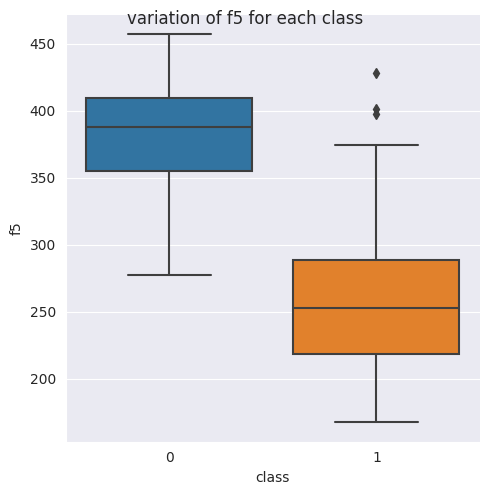

In [44]:
# let's better understand the numerical features vary depending the target

def num_evaluation_target(df, y, col_name):
    df_c = df.copy()
    df_c['y'] = y.copy().values
    df_c  = df_c.dropna(axis=0)
    g = sns.catplot(kind='box', data=df_c, y=col_name, x='y')
    g.fig.suptitle(f'variation of {col_name} for each class')
    g.set(xlabel="class", ylabel=col_name)
    plt.show()

for col in num_cols:
    num_evaluation_target(df, y, col)

We can see that all numerical features are quite informative. especially: f1, and f5.

### f6
f6 is a categorical feature with only 2 possible categories. A simple HotEncoding would do.

In [45]:
# let's encode f6 as no:0 and yes:1
print(df['f6'].value_counts())
# the column's integrity is verified
encode_dict = {"no":0, "yes":1}
df['f6'] = df['f6'].apply(encode_dict.get)

yes    483
no     442
Name: f6, dtype: int64


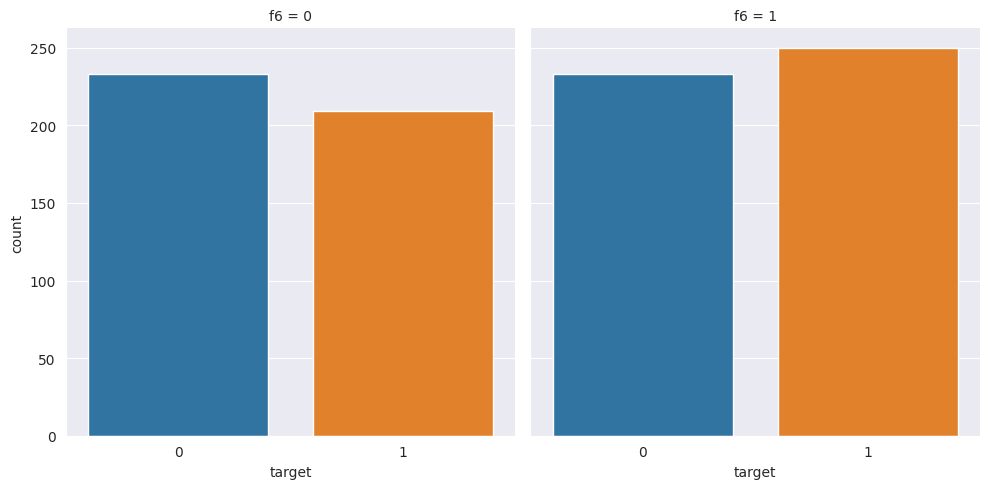

          f6         y
f6  1.000000  0.044705
y   0.044705  1.000000


In [46]:
df['y'] = y.copy().values
g = sns.catplot(kind='count', ci=None, data=df, x='y', col='f6', col_order=[0, 1])
g.set(xlabel='target')
plt.show()

# the plot above reveals the value of 'f6' has little to no effect the final classification
# let's calcuate the corretation between these two values to solidify this observation
print(df.loc[:, ['f6', 'y']].corr())
df.drop('y', axis=1, inplace=True)

### fixing f7
As the 7th column includes invalid dates, more preprocessing is needed.

In [47]:
# let's set the last column to datetime for further manipulation
try:    
    df['f7'] = pd.to_datetime(df['f7']) 
except:
    print("Certain dates are semantically invalid")
    
from dateutil import parser

# for futher manipulation we need to determine the invalid dates
def validate_dates(row):
    try:
        row['valid_date'] = parser.parse(row['f7']) # if the data isinvalid an error will raise,
    except ValueError:
        row['valid_date'] = False # the except block will catch it and set the field to False
    return row

df = df.apply(validate_dates, axis=1)
invalid_dates = df[df['valid_date'] == False]['f7'].values
# drop the additional column
df.drop('valid_date', axis=1, inplace=True)

Certain dates are semantically invalid


In [48]:
print(invalid_dates) # this is the list of invalid dates in the dataframes
# let's reduce these dates by 24 hours

def fix_dates(row):
    if row['f7'] in invalid_dates:
        date, time = row['f7'].split()
        # change the 29 to 28
        date = date[:-2] + "28"
        row['f7'] = date + " " + time
    return row

df = df.apply(fix_dates, axis=1)

df['f7'] = pd.to_datetime(df['f7'])

['2019-02-29 12:31:57' '2019-02-29 18:06:21' '2019-02-29 11:00:06'
 '2019-02-29 23:56:06' '2019-02-29 19:26:35']


In [49]:
print(df.dtypes)
# now that the 7th column is converted to datetime, we can futher break it down and tackle each component of the date: year, month, day, time
year = 'year'
month = 'month'
day = 'day'
time = 'time'
date_cols = [year, month, day, time]
def decompose_date(row):
    row[year] = row['f7'].year
    row[month] = row['f7'].month
    row[day] = row['f7'].day
    row[time] = row['f7'].time
    return row

df = df.apply(decompose_date, axis=1)

f1           float64
f2           float64
f3            object
f4           float64
f5           float64
f6             int64
f7    datetime64[ns]
dtype: object


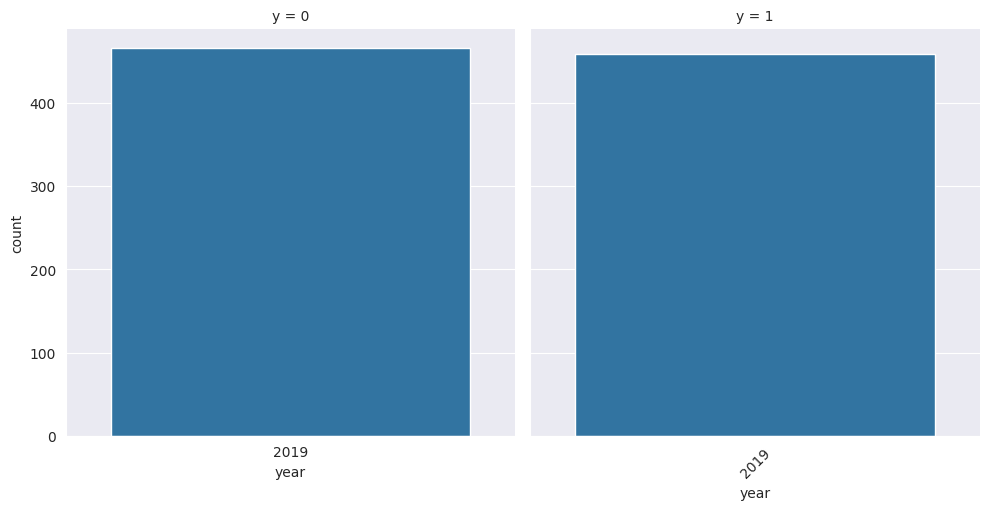

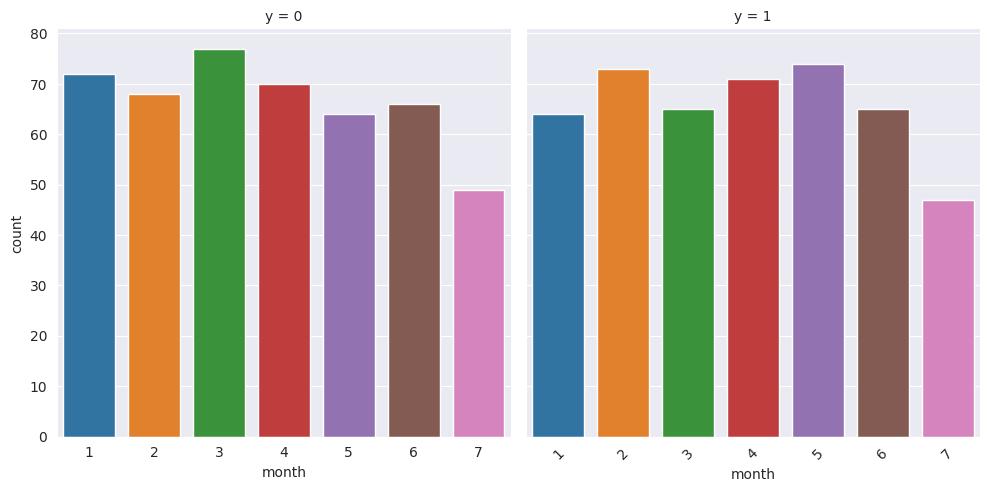

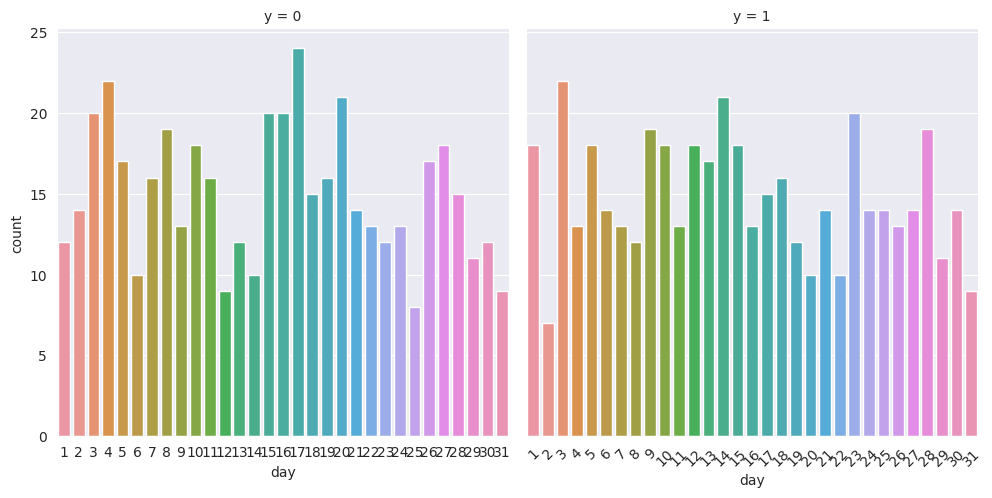

In [50]:
for c in date_cols[:-1]: # the time column has a significantly large number of unique values.
    df_c = df.copy()
    df_c['y'] = y
    fig = sns.catplot(data=df_c, kind='count', x=c, col='y', col_order=[0, 1])
    fig.set(xlabel=c, ylabel='count')
    plt.xticks(rotation=45)
    plt.show()

These are my observations:
* there is only one year present in all dates: 2019. The year can be dropped then
* The dataset is clearly not a time-series dataset where each second, minute or even hour is important, so the time part can be dropped as well
* The datasets clearly consideres different countries. Thus, it is safe to assume that the phenomena, data measure takes time to vary and the exact day of the month might not be too significant

The f7 column is reduced to its month value. The month value represents an encoding as well. 

In [51]:
df = df.drop(year, axis=1)
df = df.drop(time, axis=1)
df = df.drop(day, axis=1)
df = df.drop('f7', axis=1)

### f3: the area column
This column seems quite important as it represent areas / regions which is likely to affect the target value. As it saved as string objects, some standarization and cleaning is needed

In [52]:
def clean_country(row):
    row['f3'] = row['f3'].strip().lower()
    # remove any string between parentheses if they exist
    row['f3'] = re.sub('\(.*\)', "", row['f3'])
    # remove any string between brackets if they exist
    row['f3'] = re.sub('\[.*\]', "", row['f3'])
    return row

df = df.apply(clean_country, axis=1)

### Month, area and target
In this section I will study the effect of the combination: month, area, and target class on the different numerical values (except 'f4').
The procedure can be described as follows:
* separate the positive and negative rows into two dataframes
* for each dataframe group the rows by 'f3' and aggregate a given numerical feature on the month column: calculate the mean value at each month by country (area/f3)
* visualize the evolution of the mean with respect to month column


The mean in this case is a representative statistic as there is a less than 3 values for each combination of (country, month)

In [53]:
import random
df['y'] = y.values
df_1 = df[df['y'] == 1]
df_0 = df[df['y'] == 0]


def feat_month_country(feat, aggs=None, num_display=2, num_samples=20):
    if aggs is None:
        aggs = [np.mean]
    # visualize positive 
    f_months1 = pd.pivot_table(df_1, index='f3', columns=month, values=feat, aggfunc=[np.mean]) # calculate the mean of the feature accross different months for positive rows
    f_months0 = pd.pivot_table(df_0, index='f3', columns=month, values=feat, aggfunc=[np.mean]) # calculate the mean of the feature accross different months for negative rows

    for i in range(1, num_display + 1):
        c0 = f_months1.index.values.tolist()
        c0_sample = random.sample(c0, min(num_samples, len(c0))) 

        for c in c0_sample:
            g = sns.lineplot(x=range(1, 8), y=f_months1.loc[c,:])
        g.set(xlabel='months', ylabel=feat, label=c)
        g.set_title(f"evolution of {feat} with respect to months for positive areas: random sample {str(i)}")
        plt.show()
        
    # visualize negative
    for i in range(1, num_display + 1):
        c0 = f_months0.index.values.tolist()
        c0_sample = random.sample(c0, min(num_samples, len(c0))) 

        for c in c0_sample:
            g = sns.lineplot(x=range(1, 8), y=f_months0.loc[c,:])
        g.set(xlabel='months', ylabel=feat, label=c)
        g.set_title(f"evolution of {feat} with respect to months for positive areas: random sample {str(i)}")
        plt.show()
    

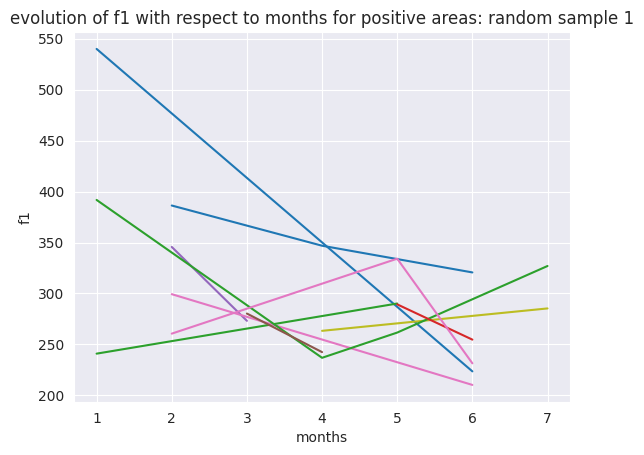

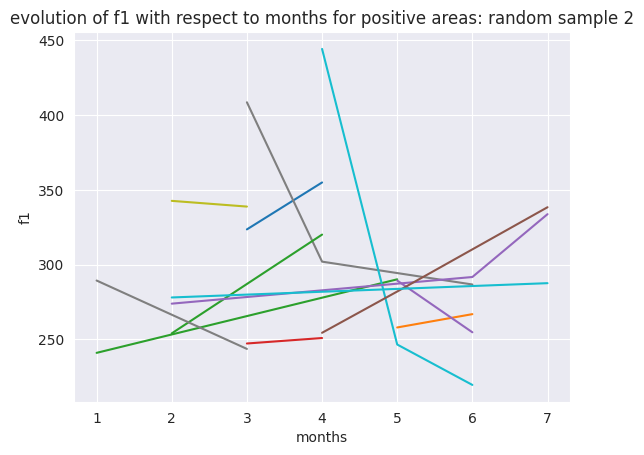

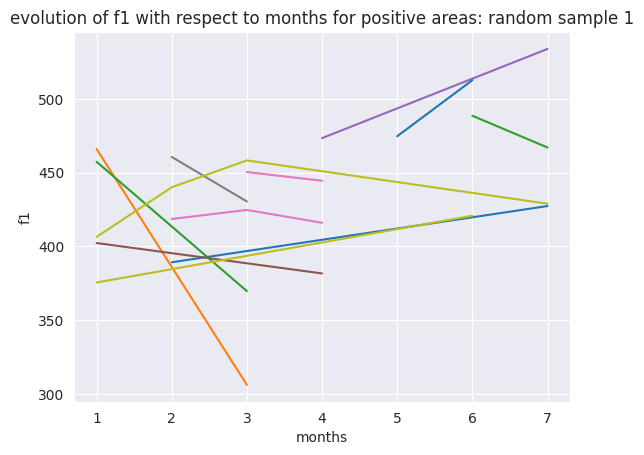

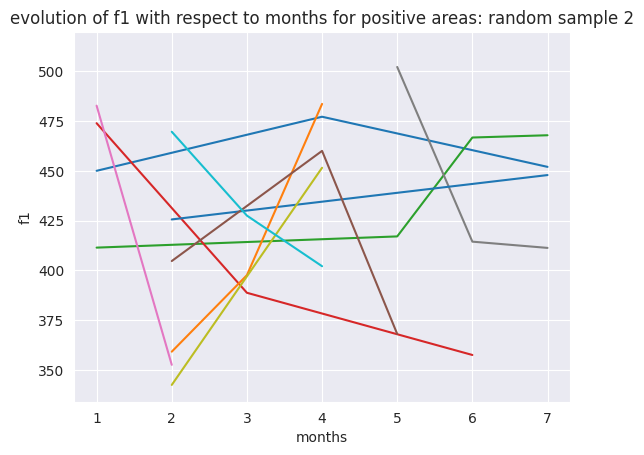

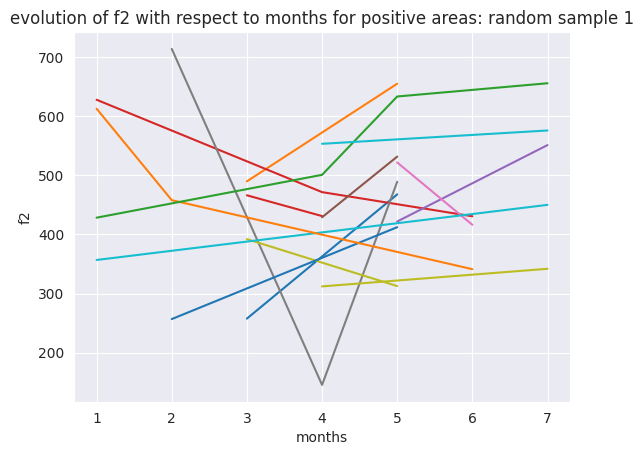

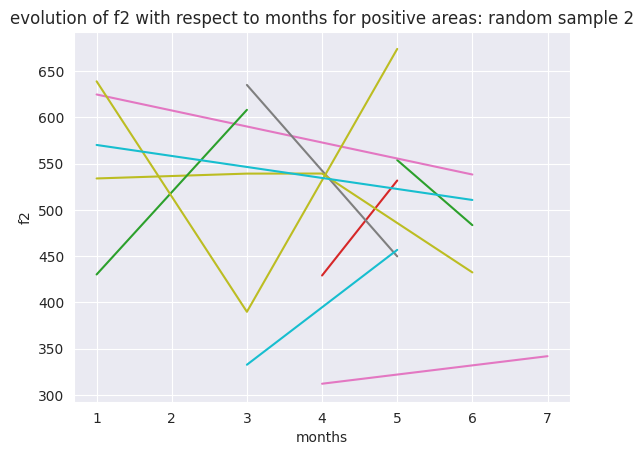

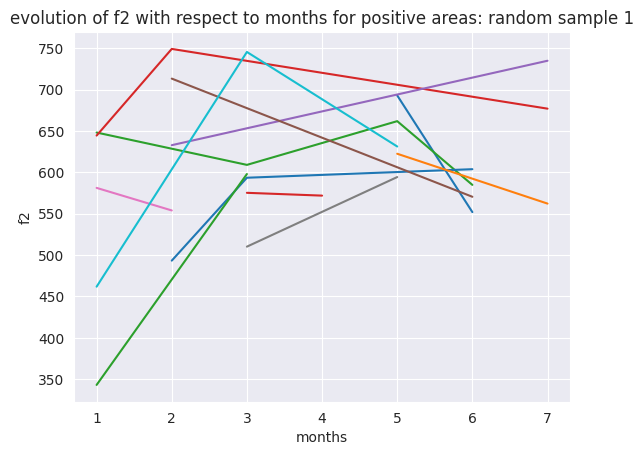

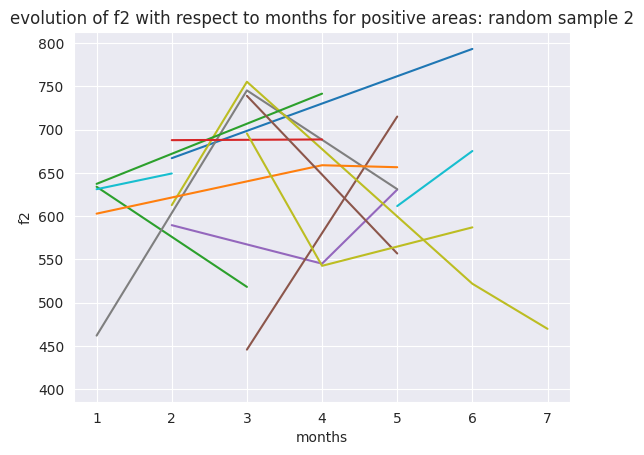

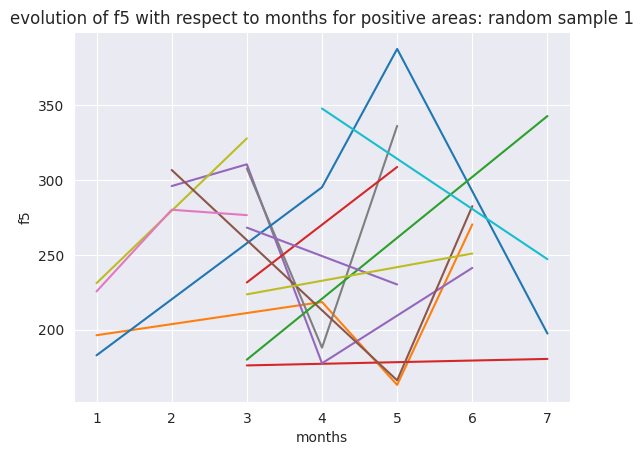

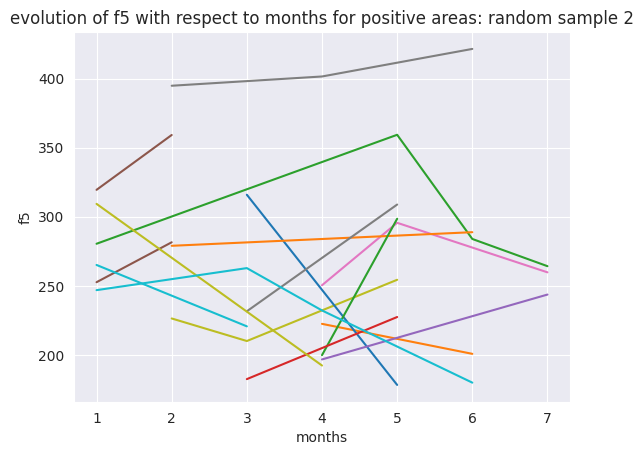

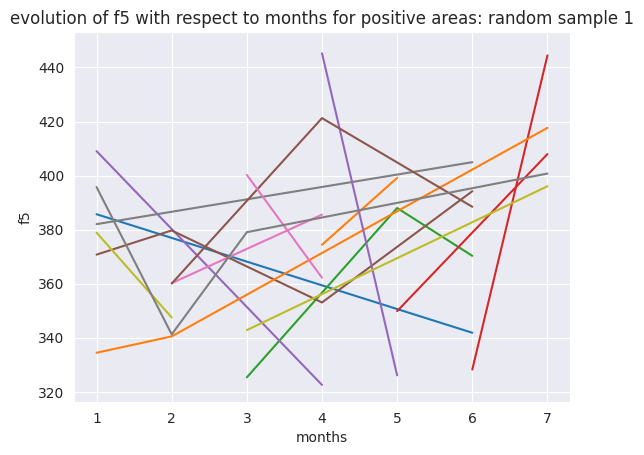

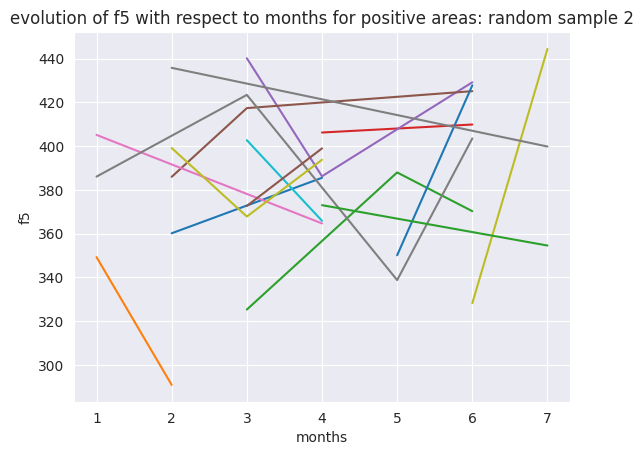

      count      mean
         f6        f6
month                
1       136  0.536765
2       141  0.553191
3       142  0.436620
4       141  0.531915
5       138  0.536232
6       131  0.511450
7        96  0.562500


In [54]:
cols = ['f1', 'f2', 'f5']
for c in cols:
    feat_month_country(c)
print(pd.pivot_table(df, index=month, values='f6', aggfunc=['count', 'mean'])) # the month does not correlate with f6.

The combination country, date (month) and target does not determine by any means the evolution of the numerical values as well as 'f6'.
Thus, we can safely assume the month + country combination has little to no correlation with the numerical features. 

### Month column
Let's consider the only value left out of the f7 column and its interactions with the rest of the columns. This is best achieved using box plots.

In [55]:
def feat_month(feat, aggs=None):
    if aggs is None:
        aggs = [np.mean]
    f_month = pd.pivot_table(df, index=month, values=feat, aggfunc=aggs)
    for stat in aggs:
        fig = sns.relplot(kind="line", ci=None, data=f_month, x='month', y=f_month[(stat, feat)])
        fig.fig.suptitle(f"{stat}'s variation of {feat} with respect to the month")
    plt.show()

/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: 

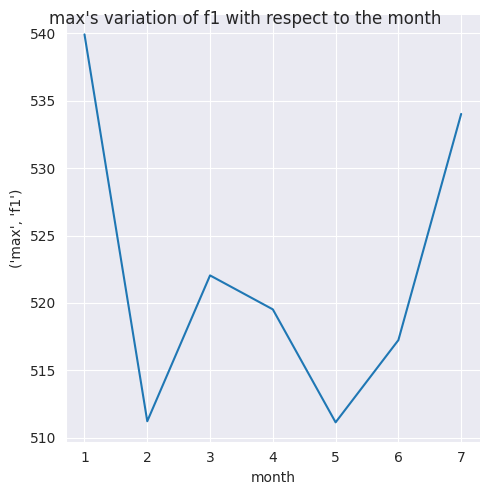

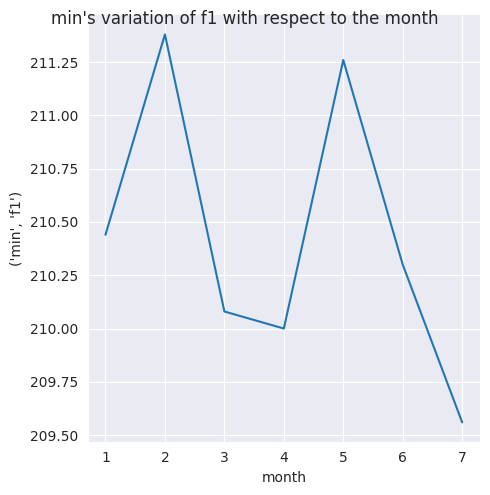

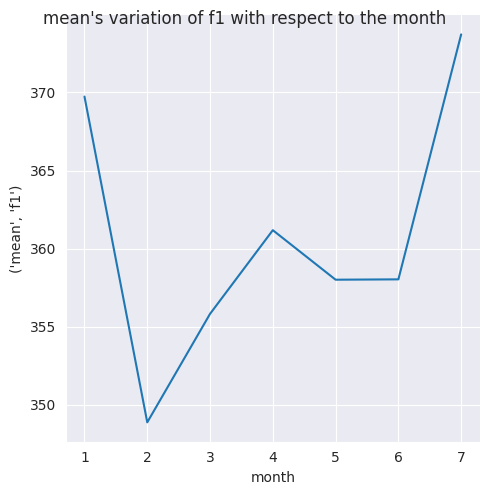

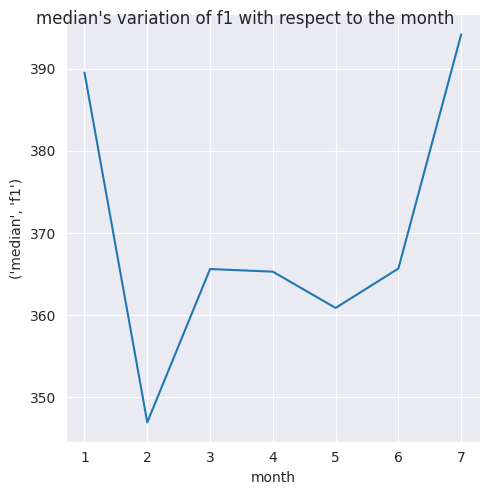

/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: 

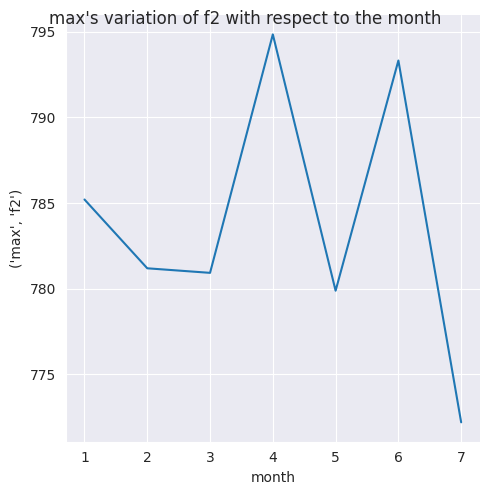

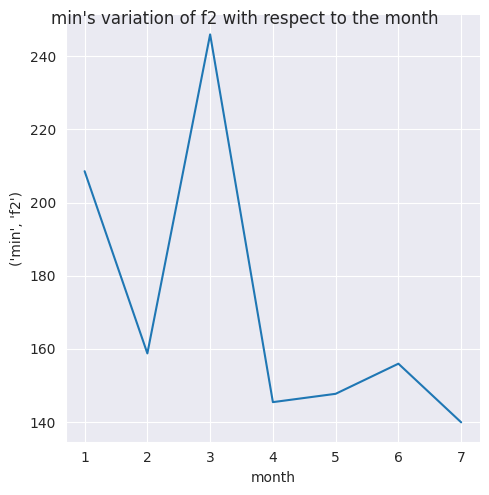

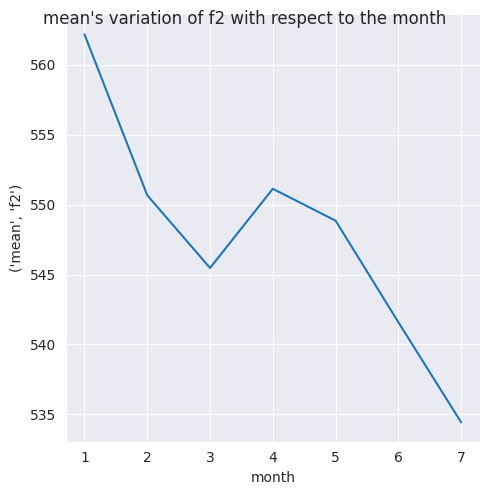

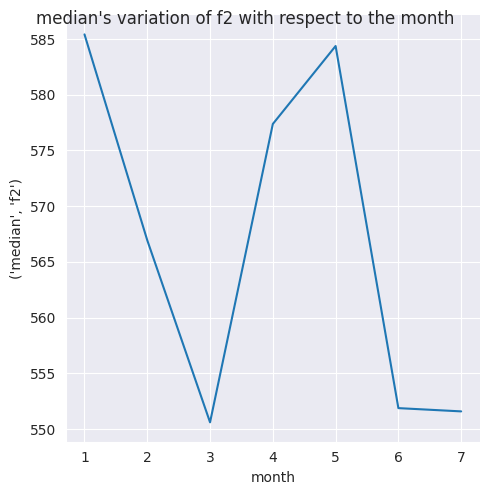

/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(
/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: 

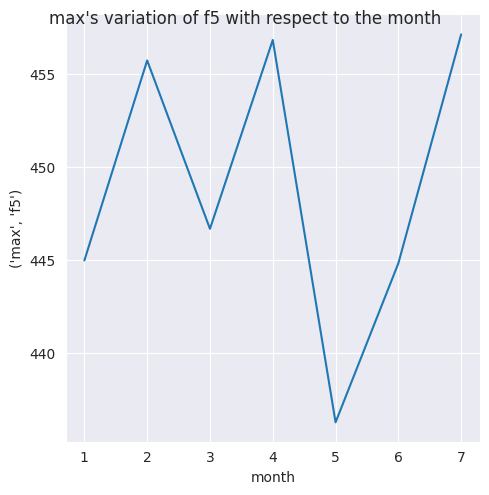

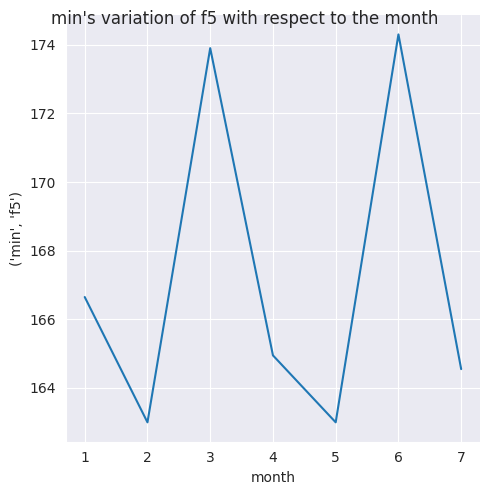

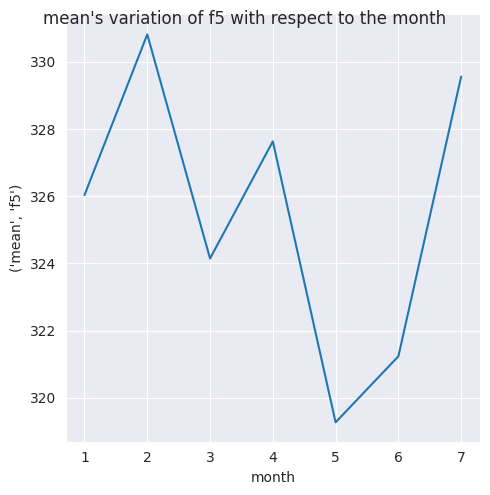

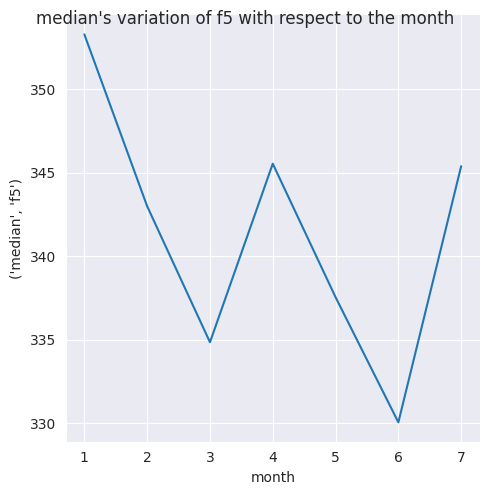

In [56]:
for f in ['f1', 'f2', 'f5']:
    feat_month(f, ['max', 'min', 'mean', 'median'])

#### Conclusion
The f7 column reduced to the month column has little to no correlation with the rest of the features as well as the target value. This feature should be considered further for imputing 'f4'

# Imputing missing values.
The column 'f4' originally referred to as 'var4' includes 600 missing values. Before proceeding with the building models, it is necessary to impute the values.

In this subsection, we are tackling a sub problem. However, it is a still a different problem (a regression to say the least), so it should approached accordingly.


In [57]:
# df.drop('y', axis=1, inplace=True)
df_4 = df[~df['f4'].isna()]
df_imp = df[df['f4'].isna()]
print(df_4.shape)
print(df.columns)

(325, 8)
Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'month', 'y'], dtype='object')


/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='f4', ylabel='Density'>

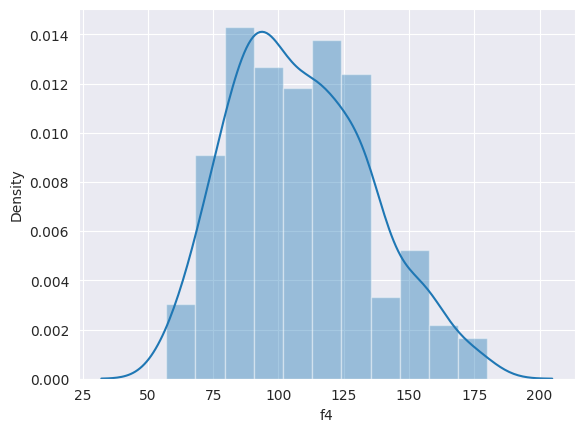

In [58]:
sns.distplot(df_4['f4'])
# we can see that the distribution of 'f4' is not too far from normal distribution.

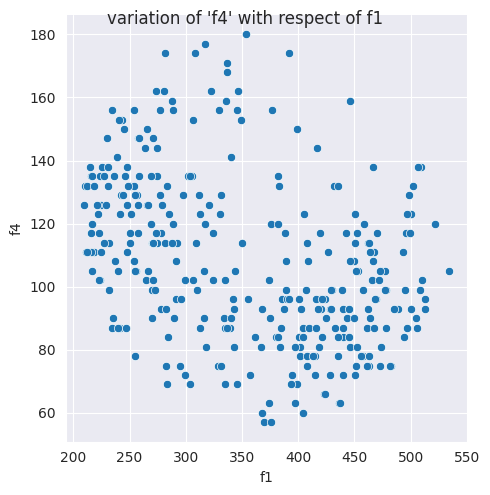

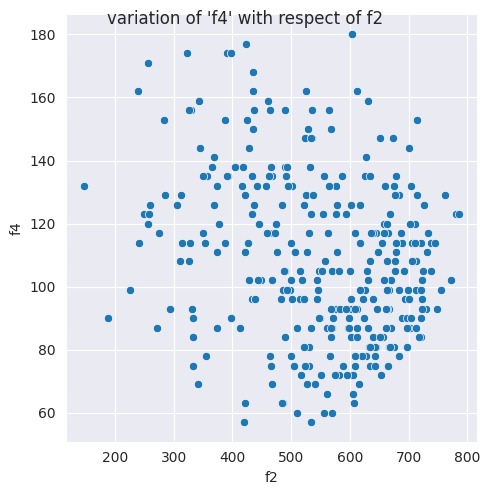

In [59]:
# let's visualize the relation of 'f4' with the rest of the columns
for col in num_cols[:-2]:
    g = sns.relplot(kind='scatter', data=df_4, x=col, y='f4')
    g.fig.suptitle(f"variation of 'f4' with respect of {col}")
    g.set(xlabel=col, ylabel='f4')
    plt.show()

The visualizations demonstrate that the relations between f4 and the other numerical (continous) features are definitely non-linear.

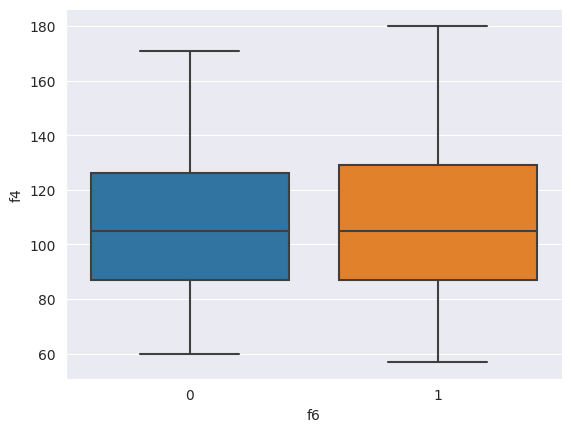

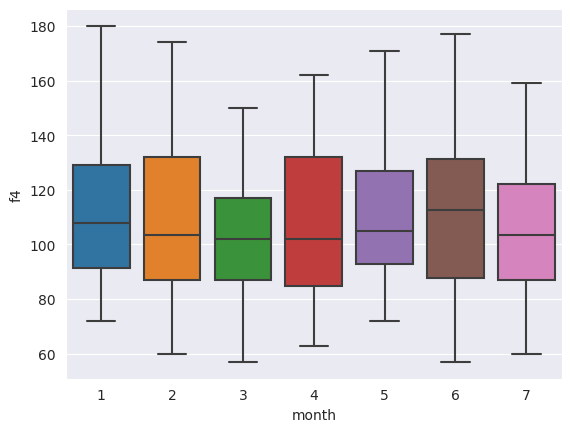

In [60]:
# let's investigate the effect of categorical features 
sns.boxplot(data=df_4, y='f4', x='f6')
plt.show()
sns.boxplot(data=df_4, y='f4', x=month)
plt.show()

Further, the first plot demonstrates that f6 provides almost no information about f4 as the variation of f4 for both categories is roughly the same. The second plot demonstrates that 'f4' varies slightly different for each month.

#### Encoding f3 for predicting f4
It is easy to see that the f3 column includes more than 200 unique values.
* One Hot Encoding: Applying this encoding will lead to a dataset with a signficantly large number of feature and a relatively small number of samples
*  Ordinal Encoding: there is no reason to believe that one area is by any computational mean can be ordered before or after another area.  

Thus the encoding of choice is ***target encoding***.  

Each area is replaced by the ***mean*** of f4 values associated with it. If an area appears in the imputed part of the data for the first time, one reasonable choice is to use the ***median*** of the f4 values associated with the ***month*** the measure was taken.

In [61]:
f4_by_area = pd.pivot_table(df_4, index='f3', values='f4', aggfunc=['count', 'max', 'min', 'mean','median'])
# f3 is the most informative predictor so far. 
f4_by_month = pd.pivot_table(df_4, index=month, values='f4', aggfunc=['count', 'median'])
def encode_area(row):
    area = row['f3']
    # encode the area as the mean of f4 for that area
    if area in f4_by_area.index.values:
        row['f3'] = f4_by_area[('mean', 'f4')][area]
    # if the area if seen for the first time: encode it as the median of f4 by corresponding month
    else:
        mo = row[month]
        row['f3'] = f4_by_month[('median', 'f4')][mo]
    return row

df_4 = df_4.apply(encode_area, axis=1)
df_imp = df_imp.apply(encode_area, axis=1)

### Imputing missing values: building models

In [62]:
# let's divide the training data into training and test data: to evaluate the performance
from sklearn.model_selection import train_test_split
yf4 = df_4['f4'].copy()
df_4.drop('f4', axis=1, inplace=True)
df_4, df_4_test, yf4, y_4_test = train_test_split(df_4, yf4, test_size=0.2, random_state=11)

In [63]:
from sklearn.preprocessing import StandardScaler
# scale the training data
scaler = StandardScaler()
Xs = scaler.fit_transform(df_4)
df_4 = pd.DataFrame(Xs, columns=df_4.columns)

# scale the test data
Xs = scaler.transform(df_4_test)
df_4_test = pd.DataFrame(Xs, columns=df_4_test.columns)

In [64]:
# prepare cross validation
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
cv = KFold(n_splits=3, shuffle=True, random_state=11)

#### Polynomial Features
As displayed above, the relations between f4 and the rest of the feature is non-linear. Linear Regression in this case is highly likely to overfit.

In [65]:
from sklearn.preprocessing import PolynomialFeatures

# I will try polynomial features with degrees 2, 3, 4, 5
# the final degree will be determined using cross validation
X_4_train = df_4.values
y_4_train = yf4.values

polys = [PolynomialFeatures(degree=i) for i in range(2, 6)]
X_trains = [p.fit_transform(X_4_train) for p in polys]    
# intiate a Linear Regression model

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

best_score = 10 ** 9
best_deg = 0
scoring = "neg_mean_squared_error"
for i in range(len(X_trains)): 
    score = -np.mean(cross_val_score(lr, X_trains[i], y_4_train, cv=cv, scoring=scoring))
    
    print(f"degree: {str(i + 2)}" )
    print(f"score: {str(np.mean(score))}")
    if best_score > score:
        best_score = score
        best_deg = i + 2
   
print(best_deg)
print(best_score)

X_train = X_trains[best_deg - 2] # set the training data
X_test = polys[best_deg - 2].transform(df_4_test.values) # set the test data

degree: 2
score: 268.1495909781037
degree: 3
score: 2301.2149079095166
degree: 4
score: 6800.832788747818
degree: 5
score: 2853.484067573581
2
268.1495909781037


After choosing the polynomial degree with the best cross validation performance, a regularized regression model is a reasonable choice as the dataset is small and any model is quite likely to overfit.

In [66]:
# as the size of the dataset is relatively small, our model is likely to overfit: Lasso and Ridge are more likely to be better options
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

lasso = Lasso()
parameters = {"alpha": [10 ** i for i in range(-3, 3)]}

lasso_search = GridSearchCV(lasso, parameters, cv=cv, scoring=scoring, n_jobs=-1)

lasso_search.fit(X_trains[best_deg - 2], y_4_train)

lasso_est = lasso_search.best_estimator_

f4_pred_lasso = lasso_est.predict(X_test)
print(mean_squared_error(y_4_test, f4_pred_lasso))

221.5991246815864


In [67]:
ridge = Ridge()
parameters = {"alpha": [10 ** i for i in range(-3, 3)]}

ridge_search = GridSearchCV(ridge, parameters, cv=cv, scoring=scoring, n_jobs=-1)

ridge_search.fit(X_trains[best_deg - 2], y_4_train)

ridge_est = ridge_search.best_estimator_ 

ridge_f4_pred = ridge_est.predict(X_test)
print(mean_squared_error(y_4_test, ridge_f4_pred))

212.78616269746217
